In [1]:
# Imports

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import os

os.chdir('..')

from src.swbm import *
from src.plots import *
from src.utils import *

In [2]:
# Load and pre-process data
input_swbm_raw = pd.read_csv('data/Data_swbm_Germany.csv')
input_swbm = prepro(input_swbm_raw)

In [12]:
# Run SWBM without seasonal variation
const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

moists, runoffs, ets = predict_ts(input_swbm, const_swbm_params)

eval_df = eval_swbm(input_swbm,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')

In [13]:
# optimize sinus params for b0
swbm_param = 'b0'
init_values = [0.5, 2, 5, 0.8]

np.random.seed(42)
const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
res = minimize(opt_swbm_corr,
                np.asarray(init_values).flatten(),  # has to be 1D
                args=(input_swbm, const_swbm_params, swbm_param),
                options={"maxiter": 500, "disp": True})
opt_params_df = minimize_res2df(res, [swbm_param])

# Set swbm const_swbm_params
params_seasonal = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

# Get sinus curve for current single parameter
params_seasonal[swbm_param] = seasonal_sinus(
    len(input_swbm),
    amplitude=opt_params_df.loc['amplitude', swbm_param],
    freq=opt_params_df.loc['freq', swbm_param],
    phase=opt_params_df.loc['phase', swbm_param],
    center=opt_params_df.loc['center', swbm_param],
    which=swbm_param
)

Optimization terminated successfully.
         Current function value: -0.893547
         Iterations: 12
         Function evaluations: 75
         Gradient evaluations: 15


In [14]:
# Run SWBM with optimized seasonal b0
preds_seasonal = predict_ts(input_swbm, params_seasonal)
moists_seasonal, runoffs_seasonal, ets_seasonal = preds_seasonal

# Test correlation
eval_df = pd.concat((eval_df, eval_swbm(input_swbm,
                                        {'sm': moists_seasonal,
                                        'ro': runoffs_seasonal,
                                        'le': ets_seasonal},
                                        swbm_param)))

In [15]:
eval_df

,parameter,kind,corr,pval
0,None\nSeasonal,sm,0.878382,0.000000e+00
1,None\nSeasonal,ro,0.483657,1.077349e-234
2,None\nSeasonal,le,-0.592983,0.000000e+00
0,b0,sm,0.893547,0.000000e+00
1,b0,ro,0.463527,3.096391e-213
2,b0,le,0.910347,0.000000e+00


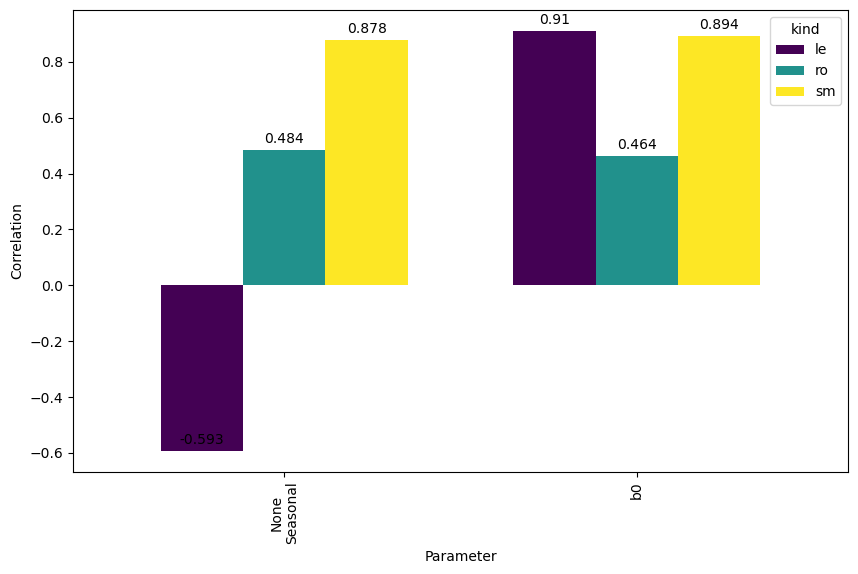

In [22]:
# PLot correlations
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr')

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(10, 6), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() + p.get_width() / 2., p.get_height()-0.01),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')

# Show the plot
plt.show()

In [30]:
input_swbm_time = input_swbm.copy()
input_swbm_time['time'] = pd.to_datetime(input_swbm_time['time'])
input_swbm_time['formatted_time'] = input_swbm_time['time'].dt.strftime('%Y-%m-%d %H:%M:%S')


TypeError: <class 'arrow.arrow.Arrow'> is not convertible to datetime, at position 0

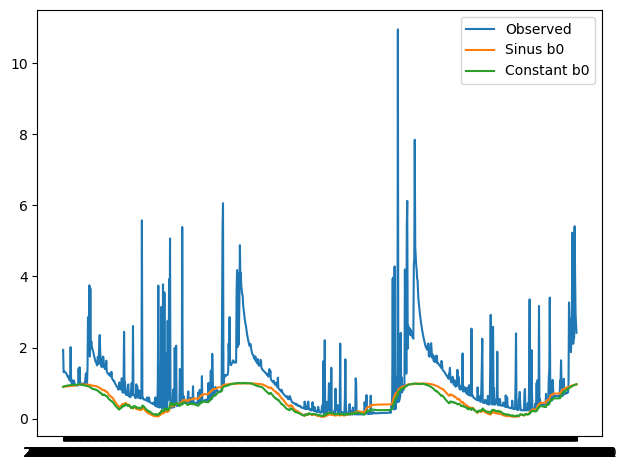

In [28]:
input_swbm_time = input_swbm.copy()
input_swbm_time['time'] = [date.format('YYYY-MM-DD')
                            for date in input_swbm['time']]
year_mask = [arrow.get(date).year == 2010 or arrow.get(date).year == 2011 or
             arrow.get(date).year == 2012 for date in input_swbm['time']]
plt.plot(input_swbm_time['time'][year_mask], input_swbm_time['ro'][year_mask],
         label='Observed')
plt.plot(input_swbm_time['time'][year_mask], runoffs_seasonal[year_mask],
         label='Sinus b0')
plt.plot(input_swbm_time['time'][year_mask], runoffs[year_mask],
         label='Constant b0')
plt.legend()
plt.tight_layout()
plt.show()